In [1]:
# --- 0. Imports ---
# Import core libraries
import pandas as pd
import numpy as np
import json
import re
import os

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Import NLP libraries
import nltk
from nltk.corpus import stopwords

# --- Initial Setup ---
# Set the default style for plots
sns.set_style("whitegrid")

# Download NLTK stopwords (only need to run once)
# These are common words (e.g., 'the', 'is', 'a') we want to ignore in text analysis.
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

print("Libraries imported and setup complete.")

Libraries imported and setup complete.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# --- 1. Load and Clean Data ---

# Reasoning: This step is vital to ensure our data is in a usable format
# for both analytics and model training. Dirty data leads to bad results.
DATA_FILE_PATH = 'data/intern_data_ikarus.csv' # Assuming it's a CSV, adjust if not.


df = pd.read_csv(DATA_FILE_PATH)
print(f"Successfully loaded data from {DATA_FILE_PATH}. Shape: {df.shape}")


# --- Data Cleaning Steps ---

# 1. Handle Duplicates
# Reasoning: We drop duplicates based on 'uniq_id' [cite: 21] to ensure that each
# product is represented only once, preventing skewed analytics.
initial_rows = df.shape[0]
df.drop_duplicates(subset='uniq_id', inplace=True)
print(f"Dropped {initial_rows - df.shape[0]} duplicate rows.")

# 2. Handle Missing Values
# Reasoning: 'description' [cite: 12] is key for NLP. We fill 'None' (NaN) values
# with an empty string to avoid errors during text processing.
df['description'] = df['description'].fillna('')

# Reasoning: 'price', 'title', and 'categories' are critical for our app.
# If they are missing, the product is not very useful. We will drop rows
# where these essential columns are null.
df.dropna(subset=['price', 'title', 'categories'], inplace=True)
print(f"Data shape after dropping critical NaN values: {df.shape}")

# 3. Type Conversion: 'categories'
# Reasoning: The 'categories' column [cite: 14] is a string representation of a list.
# We must parse it into a proper list to perform categorical analysis.
# A regex search for quoted strings is safer than using eval().
def parse_string_list(x):
    try:
        # This regex finds all strings inside single quotes
        return re.findall(r"'(.*?)'", str(x))
    except:
        return []

df['categories_list'] = df['categories'].apply(parse_string_list)

# Reasoning: For many analytics, it's easier to use a single "primary" category.
# We'll assume the *last* item in the category list is the most specific one.
df['primary_category'] = df['categories_list'].apply(lambda x: x[-1] if len(x) > 0 else 'Unknown')

# 4. Type Conversion: 'price'
# Reasoning: Ensure 'price' [cite: 13] is a numeric type. Sometimes prices are
# stored as strings (e.g., "$199.99"). This code cleans and converts it.
if df['price'].dtype == 'object':
    df['price'] = pd.to_numeric(df['price'].replace(r'[$,]', '', regex=True), errors='coerce')
    df.dropna(subset=['price'], inplace=True) # Drop rows where price couldn't be converted

print("\n--- Data Cleaning Complete ---")
print("Cleaned DataFrame info:")
df.info()
print("\nSample data after cleaning:")
print(df[['title', 'price', 'categories_list', 'primary_category']].head())

Successfully loaded data from data/intern_data_ikarus.csv. Shape: (312, 12)
Dropped 7 duplicate rows.
Data shape after dropping critical NaN values: (210, 12)

--- Data Cleaning Complete ---
Cleaned DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 210 entries, 0 to 310
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               210 non-null    object 
 1   brand               210 non-null    object 
 2   description         210 non-null    object 
 3   price               210 non-null    float64
 4   categories          210 non-null    object 
 5   images              210 non-null    object 
 6   manufacturer        133 non-null    object 
 7   package_dimensions  204 non-null    object 
 8   country_of_origin   75 non-null     object 
 9   material            146 non-null    object 
 10  color               171 non-null    object 
 11  uniq_id             210 non-null    object 


--- Starting Exploratory Data Analysis ---


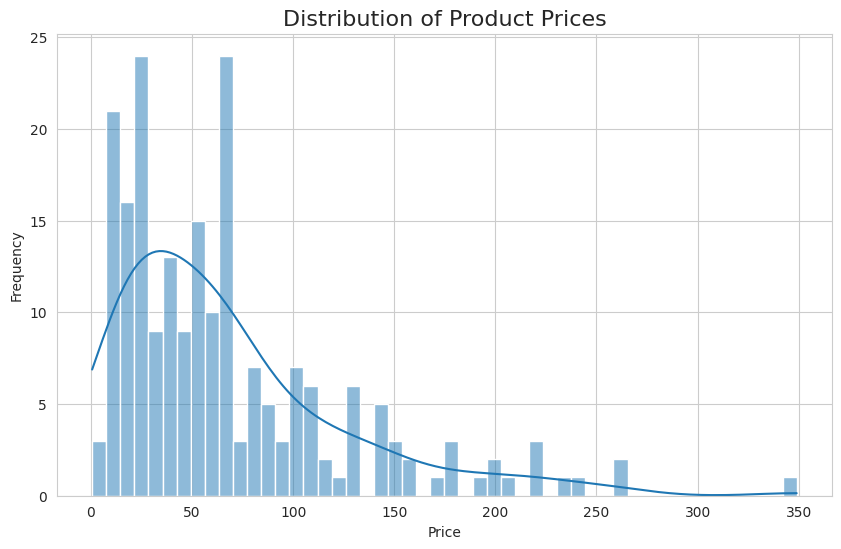

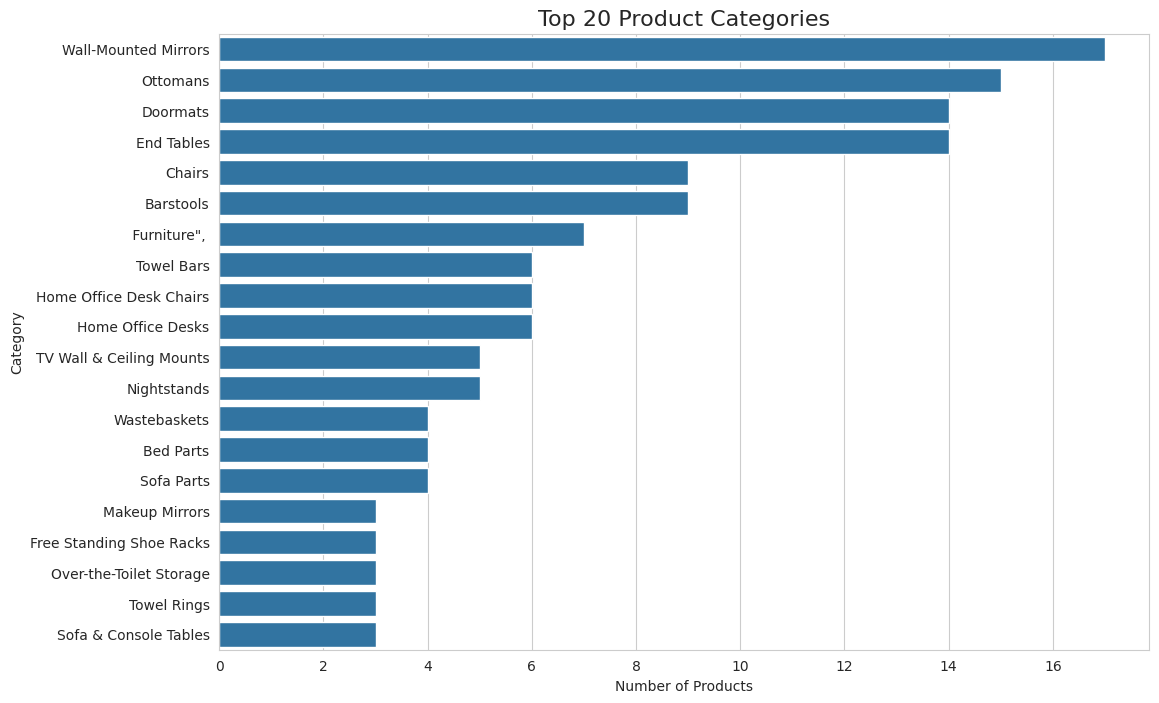

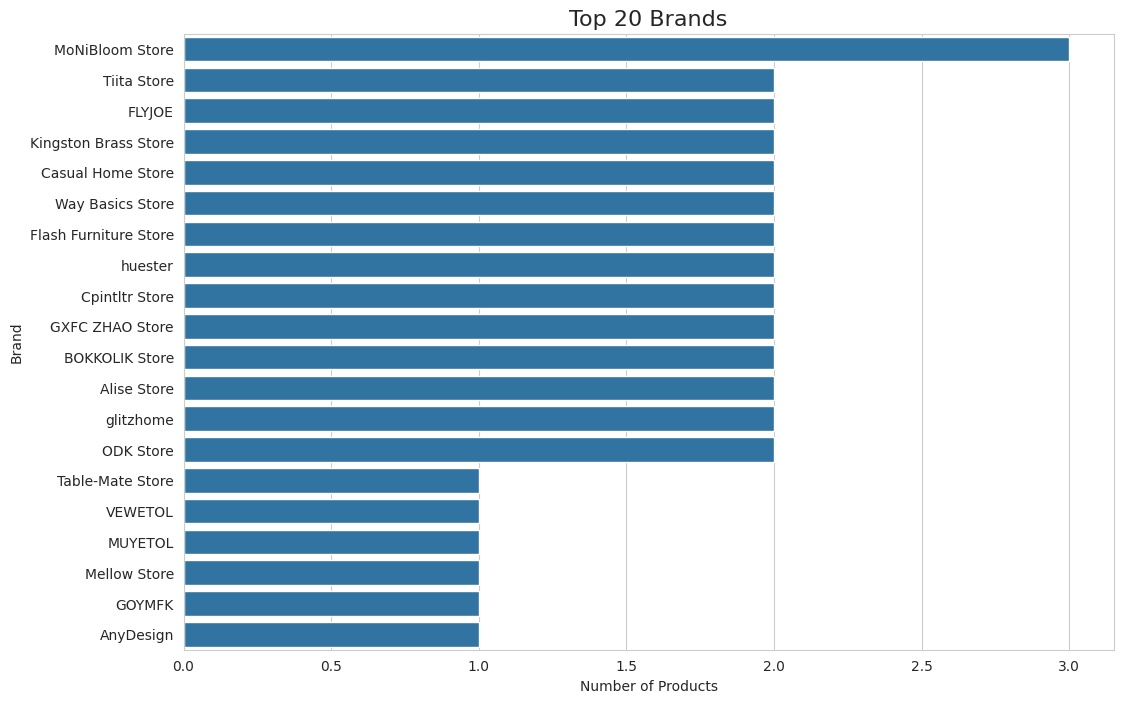

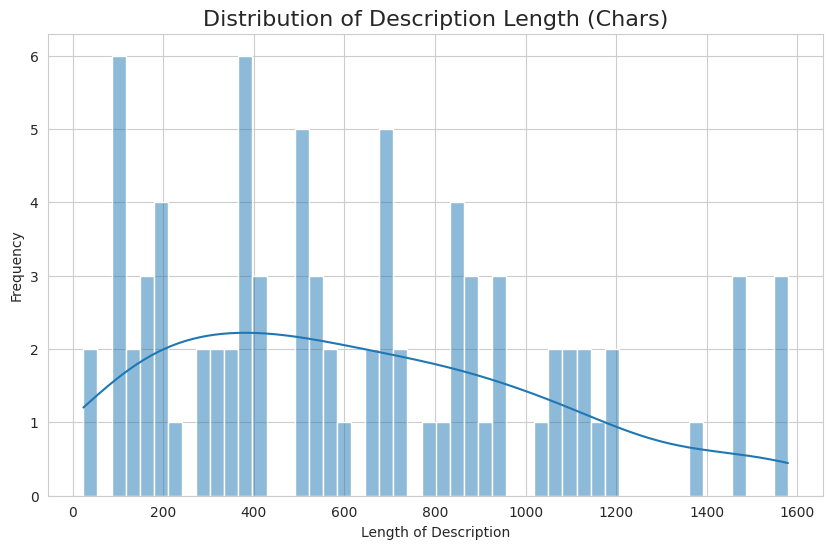

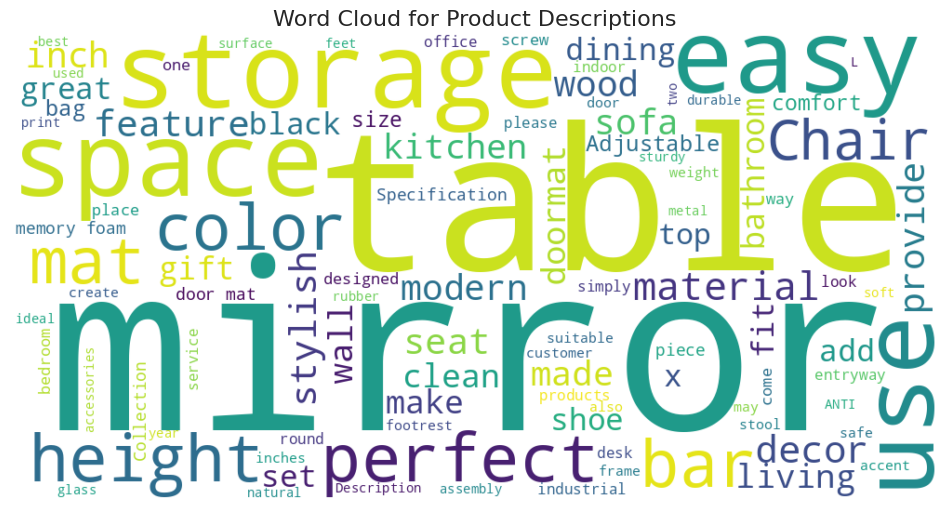

--- EDA Complete ---


In [3]:
# --- 2. Exploratory Data Analysis (EDA) ---

# Reasoning: EDA helps us visually understand the dataset's distributions
# and relationships. This informs our feature engineering for ML models
# and helps decide what charts to show on the analytics page. [cite: 8, 52]

print("\n--- Starting Exploratory Data Analysis ---")

# 1. Price Distribution
# Reasoning: Understand the range and common values for product prices.
plt.figure(figsize=(10, 6))
# Use a log scale if data is heavily skewed (uncomment if needed)
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Product Prices', fontsize=16)
plt.xlabel('Price')
plt.ylabel('Frequency')
# plt.xscale('log') # Uncomment if price is heavily skewed (e.g., few very expensive items)
plt.show()

# 2. Top Primary Categories
# Reasoning: Identify which categories have the most products.
plt.figure(figsize=(12, 8))
top_categories = df['primary_category'].value_counts().nlargest(20)
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title('Top 20 Product Categories', fontsize=16)
plt.xlabel('Number of Products')
plt.ylabel('Category')
plt.show()

# 3. Top Brands
# Reasoning: Identify the most common brands in the dataset.
plt.figure(figsize=(12, 8))
top_brands = df['brand'].value_counts().nlargest(20)
sns.barplot(x=top_brands.values, y=top_brands.index)
plt.title('Top 20 Brands', fontsize=16)
plt.xlabel('Number of Products')
plt.ylabel('Brand')
plt.show()

# 4. Text Statistics: Description Length
# Reasoning: Understanding description length helps in setting parameters
# for NLP models (e.g., max sequence length).
df['description_length'] = df['description'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df[df['description_length'] > 0]['description_length'], bins=50, kde=True)
plt.title('Distribution of Description Length (Chars)', fontsize=16)
plt.xlabel('Length of Description')
plt.ylabel('Frequency')
plt.show()

# 5. Word Cloud for Product Descriptions
# Reasoning: A word cloud gives a quick visual summary of the most frequent
# words in product descriptions. This can reveal key themes or potential
# custom stopwords (e.g., "furniture", "product").
stop_words = set(stopwords.words('english'))
# Add common, uninformative words
stop_words.update(['furniture', 'product', 'room', 'home', 'design', 'style'])

all_text = ' '.join(df['description'].dropna())

if all_text:
    wordcloud = WordCloud(width=1000, height=500, background_color='white',
                          stopwords=stop_words, max_words=100,
                          colormap='viridis').generate(all_text)

    plt.figure(figsize=(12, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Product Descriptions', fontsize=16)
    plt.show()
else:
    print("No description text found to generate a word cloud.")

print("--- EDA Complete ---")


--- Preparing Analytics Aggregates ---

Top 5 Avg Price by Category:
                primary_category   price
0                  Wine Cabinets  349.00
1                  Bedside Cribs  259.99
2              Chests & Dressers  199.00
3  Managerial & Executive Chairs  189.99
4         Computer Gaming Chairs  179.00

Top 5 Brands by Product Count:
                   brand  product_count
0        MoNiBloom Store              3
1         BOKKOLIK Store              2
2         Cpintltr Store              2
3  Flash Furniture Store              2
4        GXFC ZHAO Store              2

Top 5 Countries by Product Count:
   country  product_count
0    China             67
1   Taiwan              4
2  Morocco              1
3      USA              1
4    India              1

Top 10 Material Distribution:
          material  count
0             Wood     21
1  Engineered Wood     17
2            Metal      9
3           Rubber      9
4             Iron      6
5  Stainless Steel      5
6       

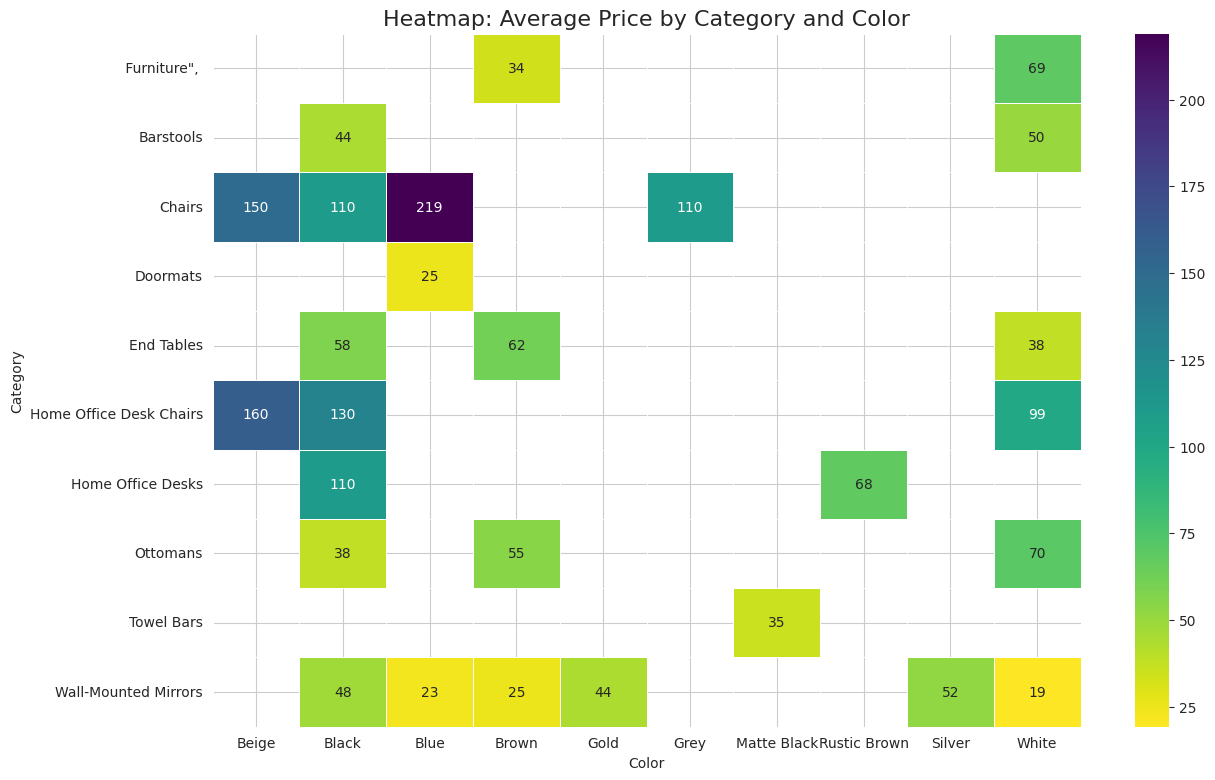

--- Analytics Aggregates Prepared ---


In [4]:
# --- 3. Analytics Preparation (Aggregates) ---

# Reasoning: We are pre-calculating key metrics that will be displayed
# on the React analytics page[cite: 8]. This is far more efficient than
# having the backend API calculate them on every page load.

print("\n--- Preparing Analytics Aggregates ---")

# 1. Average Price by Primary Category
avg_price_by_category = df.groupby('primary_category')['price'].mean().sort_values(ascending=False).reset_index()
avg_price_by_category = avg_price_by_category.round(2) # Clean up decimals
print("\nTop 5 Avg Price by Category:")
print(avg_price_by_category.head())

# 2. Product Count by Brand
products_by_brand = df.groupby('brand')['uniq_id'].count().sort_values(ascending=False).reset_index(name='product_count')
print("\nTop 5 Brands by Product Count:")
print(products_by_brand.head())

# 3. Product Count by Country of Origin
products_by_country = df['country_of_origin'].value_counts().reset_index(name='product_count')
products_by_country.columns = ['country', 'product_count']
print("\nTop 5 Countries by Product Count:")
print(products_by_country.head())

# 4. Pie Chart Data: Material Distribution
# Reasoning: This provides data for a creative pie chart [cite: 62]
# showing the makeup of product materials.
material_distribution = df['material'].value_counts().nlargest(10).reset_index(name='count')
material_distribution.columns = ['material', 'count']
print("\nTop 10 Material Distribution:")
print(material_distribution)

# 5. Heatmap Data: Average Price by Category and Color
# Reasoning: This creative viz [cite: 62] will show price correlations
# between top categories and common colors.
top_10_cats = df['primary_category'].value_counts().nlargest(10).index
top_10_colors = df['color'].value_counts().nlargest(10).index

df_filtered = df[df['primary_category'].isin(top_10_cats) & df['color'].isin(top_10_colors)]

# Create a pivot table for the heatmap
heatmap_data = pd.pivot_table(df_filtered, values='price',
                              index='primary_category', columns='color',
                              aggfunc='mean')

# Plot the heatmap in the notebook for verification
plt.figure(figsize=(14, 9))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="viridis_r", linewidths=.5)
plt.title('Heatmap: Average Price by Category and Color', fontsize=16)
plt.xlabel('Color')
plt.ylabel('Category')
plt.show()

print("--- Analytics Aggregates Prepared ---")

In [5]:
# --- 4. Export Aggregates for React Frontend ---

# Reasoning: We compile all our aggregated DataFrames into a single
# JSON object. The React app [cite: 36] can then fetch this one file and use its
# contents to populate all the charts on the analytics page .

analytics_data = {
    # Data for a bar chart: Avg Price by Category
    'avgPriceByCategory': avg_price_by_category.to_dict('records'),

    # Data for a bar chart: Product Count by Brand
    'productsByBrand': products_by_brand.nlargest(20, 'product_count').to_dict('records'),

    # Data for a world map or bar chart: Product Count by Country
    'productsByCountry': products_by_country.nlargest(20, 'product_count').to_dict('records'),

    # Data for a pie chart: Material Distribution [cite: 62]
    'materialDistribution': material_distribution.to_dict('records'),

    # Data for a Heatmap [cite: 62]
    'priceHeatmap': {
        'categories': heatmap_data.index.tolist(),
        'columns': heatmap_data.columns.tolist(),
        # We fill NaN with 0 for JSON compatibility and to show no data
        'values': heatmap_data.fillna(0).values.tolist()
    },

    # General statistics for "Key Metrics" cards
    'keyMetrics': {
        'totalProducts': df.shape[0],
        'uniqueBrands': df['brand'].nunique(),
        'averagePrice': round(df['price'].mean(), 2),
        'uniqueCategories': df['primary_category'].nunique()
    }
}

# Define the export path
EXPORT_PATH = 'data/analytics_summary.json'

# Save the file
try:
    with open(EXPORT_PATH, 'w') as f:
        json.dump(analytics_data, f, indent=4)
    print(f"\n--- Success! ---")
    print(f"Successfully exported analytics data to {EXPORT_PATH}")
except Exception as e:
    print(f"\n--- Error ---")
    print(f"Failed to export data: {e}")


--- Success! ---
Successfully exported analytics data to data/analytics_summary.json
